<a href="https://colab.research.google.com/github/ibenatar-96/Bayesian-Modelling-RL/blob/main/bayesian_modelling_mdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/
!pip install numpyro
!git clone https://github.com/ibenatar-96/Bayesian-Modelling-RL
%cd /content/Bayesian-Modelling-RL
!git pull
%cd /content/

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.6/312.6 kB 4.3 MB/s eta 0:00:00
Cloning into 'Bayesian-Modelling-RL'...
remote: Enumerating objects: 441, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 441 (delta 55), reused 57 (delta 25), pack-reused 335
Receiving objects: 100% (441/441), 9.55 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (254/254), done.
/content/Bayesian-Modelling-RL
Already up to date.
/content


In [ ]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import jax
import sys
import os
import time
sys.path.append('/content/Bayesian-Modelling-RL')
import actions
import environment
import utils
import solver
import actions

numpyro.set_host_device_count(4)

In [ ]:
def init_env(log_file):
    """
    Inits runtime env, opens new observations log file, and resets utils.INIT_MODEL_PARAMETERS,
    which is a dictionary that holds initial user belief about action probabilities
    for example, utils.INIT_MODEL_PARAMETERS = {
        ('ai_mark', 5): 0.8,
        ('ai_mark', 1): 1.0),
        ...
    }
    For every action in actions_module that does not appear in the INIT_MODEL_PARAMETERS, it sets a new entry in the dict with value 1.0
    """
    open(log_file, 'w').close()
    for (fn_action, action_param) in actions.Actions().get_actions():
        if fn_action not in utils.IGNORE_ACTIONS and (fn_action, action_param) not in utils.INIT_MODEL_PARAMETERS:
            utils.INIT_MODEL_PARAMETERS[(fn_action, action_param)] = 1.0

In [ ]:
log_file = "observations.log"
init_env(log_file)
model_parameters = utils.INIT_MODEL_PARAMETERS
slvr = solver.Solver(model_parameters, environment, log_file)
slvr.run()

Agent Q-Learning: 100%|██████████| 50/50 [00:02<00:00, 23.06it/s]


Total Time: 0:00:02.179860
Agent Playing REAL PARAMETERS Tic-Tac-Toe

	Testing 12 Tic-Tac-Toe Games


Agent Playing Tic-Tac-Toe..: 100%|██████████| 12/12 [00:00<00:00, 78.17it/s]

	Total Games Won: 4/12



	Playing Real & Collecting Logs 15 Tic-Tac-Toe Games


Playing Real Tic-Tac-Toe & Collecting Logs..: 100%|██████████| 15/15 [00:00<00:00, 73.35it/s]

	Total Games Won: 3/15


In [ ]:
model_beta_parameters = {}
fn_numeric_mapping = {}
posterior_model_parameters = {}

# Parsing Observation file
As defined in the description.

Initialization:
\
$ \quad 1.\;fn\_numeric\_mapping = \{'ai\_mark':\;0\} $
\
$ \quad 2.\;model\_beta\_parameters = \{(0,1):\; \{\alpha:\;1,\;\beta:1\},\;(0,2):\;\{\alpha:\;1,\;\beta:1\},\;...,\; (0,9):\; \{\alpha:\;1,\;\beta:1\}\} $

\
Returns:
\
$\quad obs\;list = [(state,\;(function\;number, action\;parameter),\;next\;state),\;...]$

In [ ]:
def parse_obs(obs_file):
    """
    Parses the Observation File, returns a List of tuples,
    where each tuple is composed of (State, (Function, Action Parameter), Next State)
    for example:
    State: [-1, 1, 0, -1, 0, -1, 1, 0, 0] where -1 indicates 'X' on the Board, 1 indicates 'O', and 0 indicates None (empty cell)
    (Function, Action Parameter): (0, 5) -> 0 is the number assigned for the function 'ai_mark', mapping is located in fn_numeric_mapping
    Next State: [-1, 1, 0, -1, 1, -1, 1, 0, 0].

    0 is mapped to 'ai_mark' function in global fn_numeric_mapping variable. This mapping exists because NumPyro
    MCMC expects numeric values when running inference.

    fn_numeric_mapping = {
        'ai_mark': 0,
        ...
    }

    This Function also adds initial 'alpha' and 'beta' parameters to the global model_beta_parameters for every NEW
    fn_action and action_param it encounters.
    for example - model_beta_parameters = {
    (0, 5): {'alpha': 1, 'beta': 1},
    (0, 1): {'alpha': 1, 'beta': 1} ... }
    """

    #Converts states from: [['X', 'O', None], ['X', None, 'X'], ['O', None, None]] to [-1, 1, 0, -1, 0, -1, 1, 0, 0]
    #Meaning, creating a minimal state representation, where 'X' is marked a -1, 'O' as 1, and None as 0.
    def minimal_state(state):
        minimal_repr = []
        for i in range(len(state)):
            for j in range(len(state[i])):
                if state[i][j] == 'X':
                    minimal_repr.append(-1)
                elif state[i][j] == 'O':
                    minimal_repr.append(1)
                else:
                    minimal_repr.append(0)
        return minimal_repr

    obs_list = []
    fn_numeric_count = 0
    global model_beta_parameters, fn_numeric_mapping
    with open(obs_file, "r") as obs_log:
        for episode in obs_log:
            episode = episode.strip()  # Remove leading/trailing whitespaces and newlines
            episode_list = eval(episode)  # Convert the line string to a list
            for (state, (fn_name, action_param), next_state) in episode_list:
                if fn_name in utils.IGNORE_ACTIONS:
                    continue
                if fn_name in fn_numeric_mapping.keys():
                    fn_numeric = fn_numeric_mapping[fn_name]
                else:
                    fn_numeric = fn_numeric_count
                    fn_numeric_mapping[fn_name] = fn_numeric_count
                    fn_numeric_count += 1
                obs_list.append((minimal_state(state), (fn_numeric, action_param), minimal_state(next_state)))
                if not (fn_numeric, action_param) in model_beta_parameters:
                    model_beta_parameters[(fn_numeric, action_param)] = {'alpha': 1, 'beta': 1}
    model_beta_parameters = dict(sorted(model_beta_parameters.items()))
    return obs_list

In [ ]:
obs_list = parse_obs(log_file)

# AI Model
$ p_i \sim Beta(\alpha_i, \beta_i)\;\;\;1 \le i \le number\;of\;functions\;and\;action\;parameters $

$ o_i \sim Bernoulli(p_i)\;\;\;1 \le i \le number\;of\;observations $

In [ ]:
def ai_model(obs=None):
    """
    (Tic-Tac-Toe) AI Agent model with NumPyro.
    p is a dictionary mapping (function, action parameter) -> sample from Beta distribution using (alpha, beta).
    obs = [
    ([-1,1,0,...], (0,3), [-1,1,1,...]),
    ([-1,1,...,0], (0,9), [-1,1,...,1]),
    ]
    """
    # p ~ Beta(alpha, beta)
    global model_beta_parameters
    p = {}
    for key in model_beta_parameters.keys():
        alpha = model_beta_parameters[key]['alpha']
        beta = model_beta_parameters[key]['beta']
        p[key] = numpyro.sample(f"p{str(key)}", dist.Beta(alpha, beta))
        # p = {(0,1): sample_1, (0,2): sample_2, ..., (0,9): sample_9}

    # if obs is not None:
    #     for i in range(len(obs)):
    #         s, a, snext = obs[i]
    #         p_i = p[a]
    #         success = jax.numpy.array([1 if s != snext else 0])
    #         numpyro.sample(f"success{i}", dist.Bernoulli(p_i), obs=success)

    if obs is not None:
        p_actions = jax.numpy.array([p[action] for _, action, _ in obs]) # [sample_4, sample_5, sample_2, sample_7, sample_4, sample_5, ...]
        success = jax.numpy.array([1 if state != next_state else 0 for state, _, next_state in obs]) # [1, 0, 1, 1, ...]
        with numpyro.plate("obs", size=len(obs)):
            numpyro.sample("o", dist.Bernoulli(p_actions), obs=success)


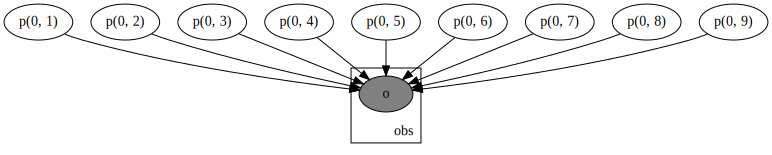

In [ ]:
numpyro.render_model(ai_model, model_args=(obs_list,))

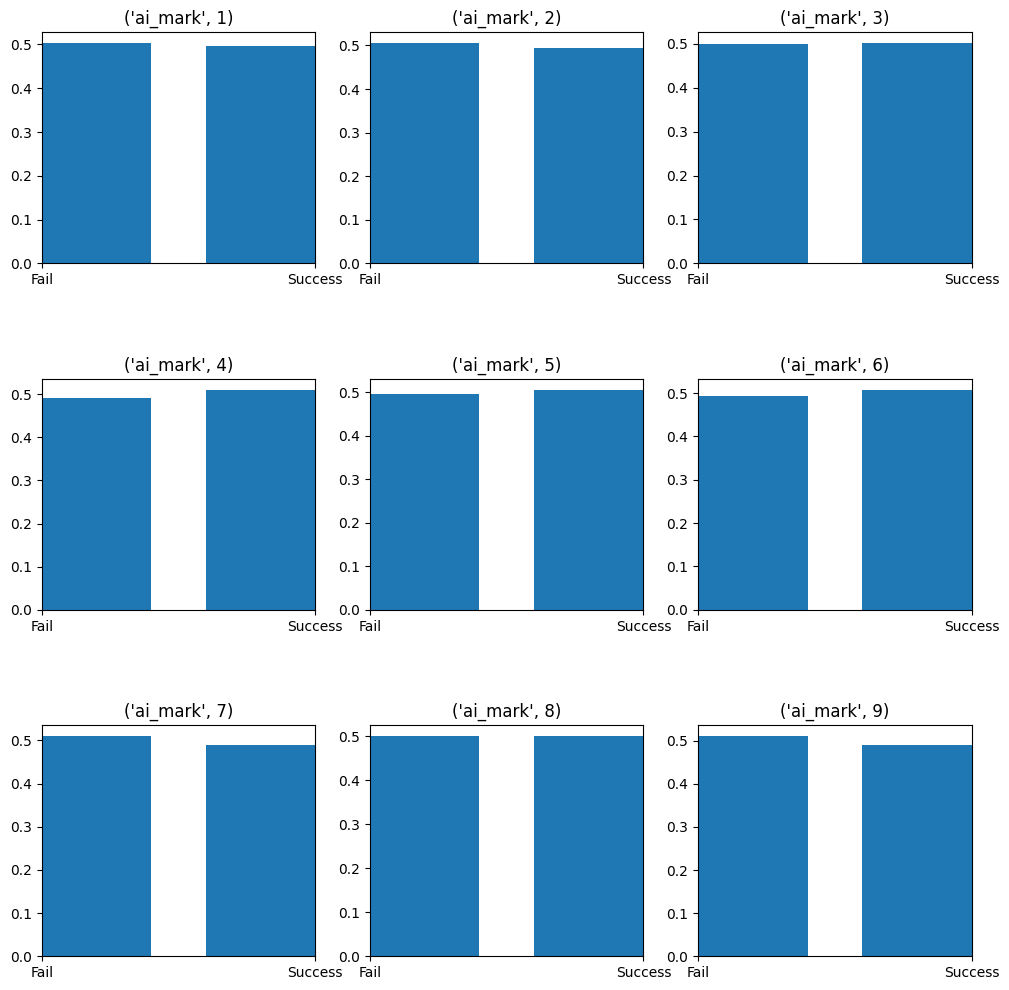

In [ ]:
"""
Evaluates Prior Predictive from the Prior Dist.
Expecting to see mass in the bar where observation and imaginations are aligned.
"""
prior_predi = numpyro.infer.Predictive(ai_model, num_samples=10000)
prior_samples = prior_predi(jax.random.PRNGKey(int(time.time() * 1E6)))

num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.title("prior predictive")
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        o_key = f"p{str((fn_num, action_param))}" # Need to revert this to o{str(key)}
        x_titles = ["Fail", "Success"]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        axs[i, j].set_title(title)
        axs[i, j].set_xlim(0, 1)
        success_counts = np.sum(prior_samples[o_key] > 0.5, axis=0)
        fail_counts = np.sum(prior_samples[o_key] < 0.5, axis=0)
        normalized_vector = [np.mean(fail_counts), np.mean(success_counts)]
        sum_normalized = np.sum(normalized_vector)
        normalized_vector /= sum_normalized
        axs[i, j].bar(x_titles, normalized_vector)
plt.show()

In [ ]:
"""
Runs Inference using MCMC.
"""
nuts_kernel = numpyro.infer.NUTS(ai_model)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=500,
    num_chains=4,
    num_samples=5000)
mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), obs=obs_list)
mcmc.print_summary()

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   p(0, 1)      0.83      0.14      0.87      0.63      1.00  29029.14      1.00
   p(0, 2)      0.86      0.12      0.89      0.68      1.00  28529.61      1.00
   p(0, 3)      0.91      0.08      0.93      0.80      1.00  25106.66      1.00
   p(0, 4)      0.91      0.08      0.93      0.80      1.00  28516.51      1.00
   p(0, 5)      0.22      0.13      0.20      0.02      0.42  28568.04      1.00
   p(0, 6)      0.83      0.14      0.87      0.63      1.00  28144.61      1.00
   p(0, 7)      0.88      0.11      0.91      0.72      1.00  30446.78      1.00
   p(0, 8)      0.86      0.12      0.89      0.68      1.00  30005.75      1.00
   p(0, 9)      0.91      0.08      0.93      0.79      1.00  30742.02      1.00

Number of divergences: 0


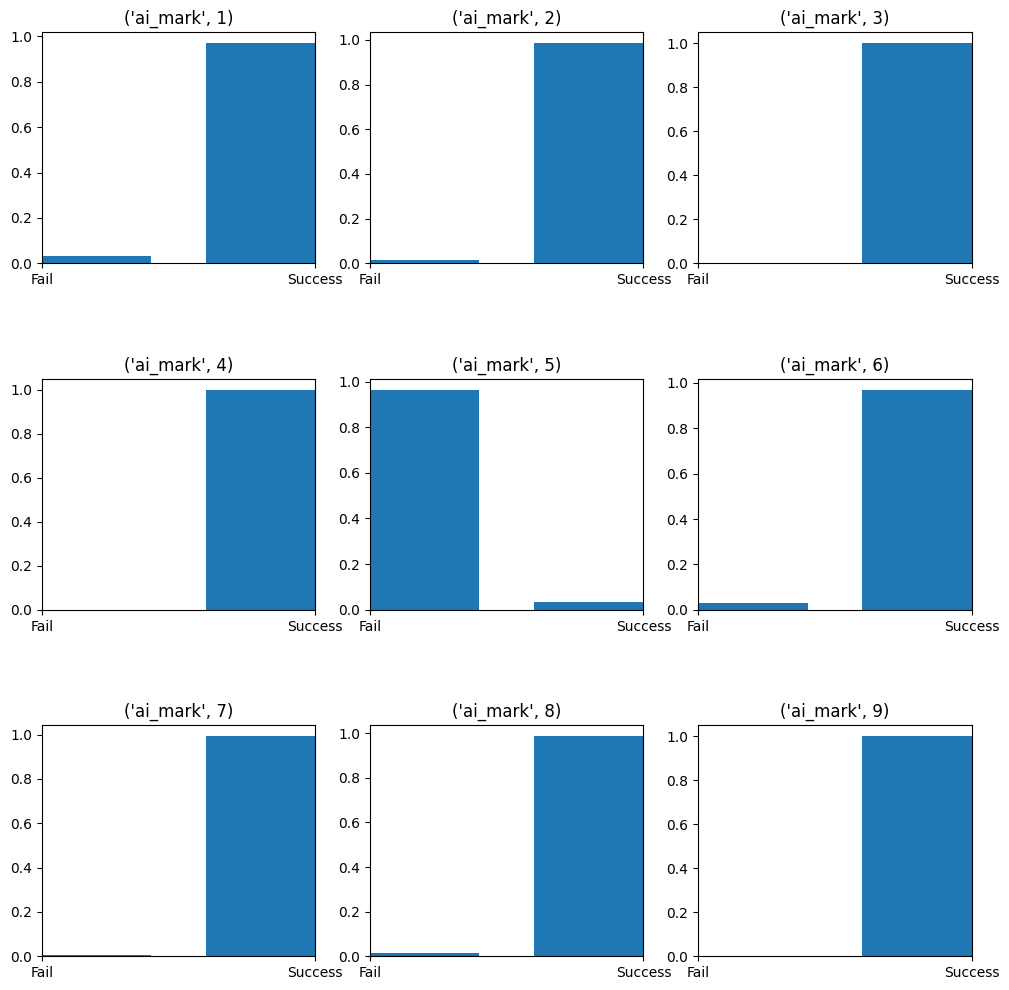

In [ ]:
num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.title("posterior")
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        p_key = f"p{str((fn_num, action_param))}"
        x_titles = ["Fail", "Success"]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        axs[i, j].set_title(title)
        axs[i, j].set_xlim(0, 1)
        success_counts = np.sum(mcmc.get_samples()[p_key] > 0.5, axis=0)
        fail_counts = np.sum(mcmc.get_samples()[p_key] < 0.5, axis=0)
        normalized_vector = [np.mean(fail_counts), np.mean(success_counts)]
        sum_normalized = np.sum(normalized_vector)
        normalized_vector /= sum_normalized
        axs[i, j].bar(x_titles, normalized_vector)

        # p_key = f"p{str(key)}"
        # axs[i, j].set_title(p_key)
        # axs[i, j].set_xlabel("p")
        # axs[i, j].hist(mcmc.get_samples()[p_key], density=True, bins='auto')
plt.show()


stat	p(0, 1)
-------------
mean	0.834
stddev	0.141
  0%	0.103
  2%	0.479
 25%	0.757
 50%	0.871
 75%	0.944
 98%	0.995
100%	1.000


stat	p(0, 2)
-------------
mean	0.857
stddev	0.123
  0%	0.156
  2%	0.544
 25%	0.792
 50%	0.891
 75%	0.953
 98%	0.995
100%	1.000


stat	p(0, 3)
-------------
mean	0.910
stddev	0.083
  0%	0.371
  2%	0.691
 25%	0.871
 50%	0.935
 75%	0.972
 98%	0.998
100%	1.000


stat	p(0, 4)
-------------
mean	0.910
stddev	0.082
  0%	0.366
  2%	0.695
 25%	0.872
 50%	0.933
 75%	0.971
 98%	0.997
100%	1.000


stat	p(0, 5)
-------------
mean	0.223
stddev	0.132
  0%	0.001
  2%	0.031
 25%	0.120
 50%	0.201
 75%	0.304
 98%	0.527
100%	0.797


stat	p(0, 6)
-------------
mean	0.833
stddev	0.140
  0%	0.157
  2%	0.479
 25%	0.757
 50%	0.871
 75%	0.944
 98%	0.995
100%	1.000


stat	p(0, 7)
-------------
mean	0.876
stddev	0.110
  0%	0.183
  2%	0.594
 25%	0.820
 50%	0.906
 75%	0.960
 98%	0.996
100%	1.000


stat	p(0, 8)
-------------
mean	0.858
stddev	0.123
  0%	0.191
  2%	0.547
 25%	0.795
 50%	0

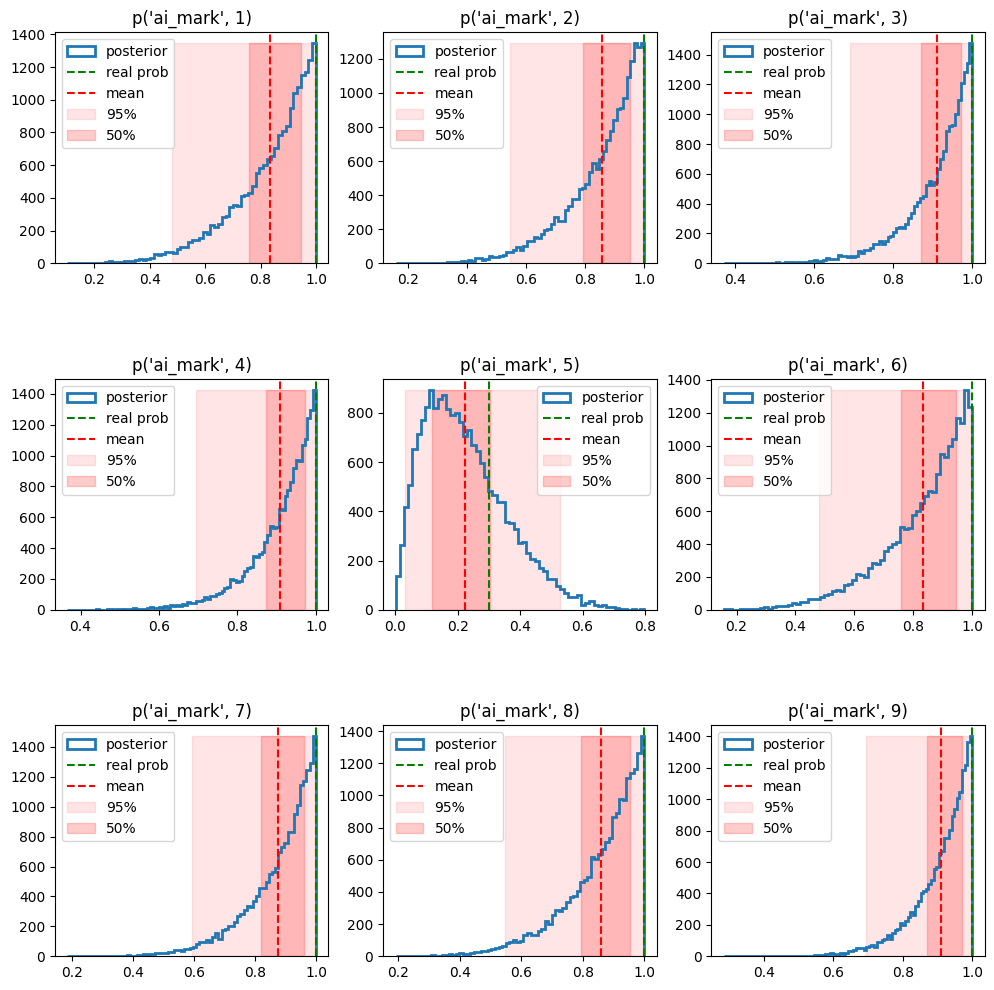

In [ ]:
"""
Summarizes Posterior, displays attributes such as mean, standard deviation, quantiles.
"""
distribution_stats = {}
num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
# obs_list = list(obs.items())
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        key = (fn_num, action_param)
        real_param = utils.REAL_MODEL_PARAMETERS[(fn_name, action_param)]
        p_key = f"p{str(key)}"
        p = mcmc.get_samples()[p_key]
        p_mean = p.mean()
        p_stddev = p.std()
        distribution_stats[key] = {'mean': p_mean, 'stddev': p_stddev}
        quantiles = [0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]
        pq = np.quantile(p, quantiles)
        print(f"stat\t{p_key}\n-------------")
        print(f"mean\t{p_mean:.3f}")
        print(f"stddev\t{p_stddev:.3f}")
        for q in range(len(quantiles)):
            print(f"{quantiles[q] * 100:3.0f}%\t{pq[q]:.3f}")
        print("\n")
        height, _, _ = axs[i, j].hist(p, histtype="step", lw=2, bins="auto", label="posterior")
        axs[i, j].set_title(f"p{title}")
        axs[i, j].axvline(real_param, ls="dashed", color="green", label="real prob")
        axs[i, j].axvline(p_mean, ls="dashed", color="red", label="mean")
        axs[i, j].fill_betweenx([0, height.max()], pq[1], pq[-2],
                                color="red", alpha=0.1, label=f"{(quantiles[-2] - quantiles[1]) * 100:.0f}%")
        axs[i, j].fill_betweenx([0, height.max()], pq[2], pq[-3],
                                color="red", alpha=0.2, label=f"{(quantiles[-3] - quantiles[2]) * 100:.0f}%")
        axs[i, j].legend()
plt.show()